# Import needed modules and useful functions

In [1]:
#-- useful python script to compute the TICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
#--------------------------------------#

# Prepare input files for plumed

In [3]:
folder = "unbias_A/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

INCLUDE FILE=plumed_descriptors.data

PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
#execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")
#execute("./run_gromacs.sh",folder=folder)

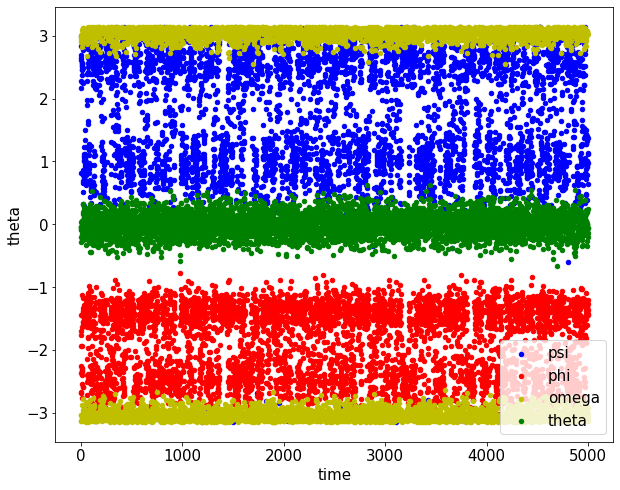

In [4]:
data = load_dataframe(folder+"COLVAR")
fig,ax = plt.subplots(1,1,figsize=(10,8))
data.plot.scatter(x="time",y="psi",ax=ax, color="b", label="psi")
data.plot.scatter(x="time",y="phi",ax=ax, color="r", label="phi")
data.plot.scatter(x="time",y="omega",ax=ax, color="y", label="omega")
data.plot.scatter(x="time",y="theta",ax=ax, color="g", label="theta")
ax.legend()

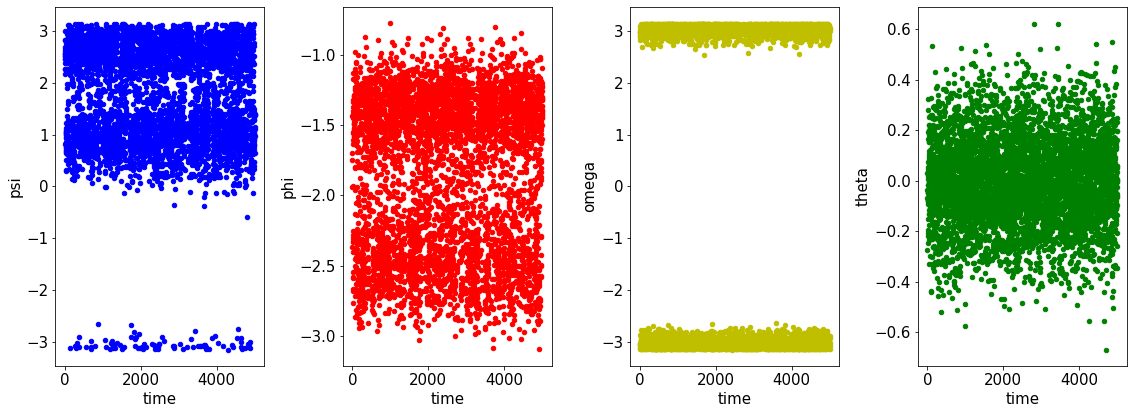

In [5]:
fig,axs = plt.subplots(1,4,figsize=(16,6))
data.plot.scatter(x="time",y="psi",ax=axs[0], color="b")
data.plot.scatter(x="time",y="phi",ax=axs[1], color="r")
data.plot.scatter(x="time",y="omega",ax=axs[2], color="y")
data.plot.scatter(x="time",y="theta",ax=axs[3], color="g")
plt.tight_layout()

Text(0, 0.5, '$\\psi$')

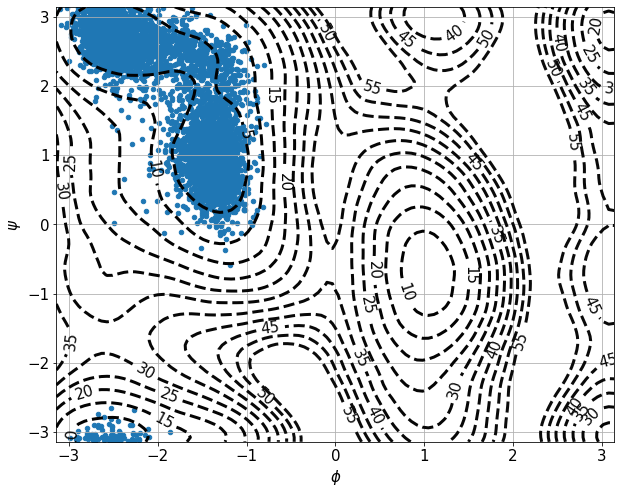

In [6]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
load_dataframe(folder+"COLVAR").plot.scatter(y="psi",x="phi",ax=ax)

fes = np.loadtxt("../../angles/fes.txt",delimiter=" ")
grid0 = np.loadtxt("../../angles/grid0.txt",delimiter=" ")
grid1 = np.loadtxt("../../angles/grid1.txt",delimiter=" ")
bounds = np.arange(0, 60, 5.)
c = ax.contour(grid0, grid1, fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
    norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
)
c.clabel()
ax.grid()
ax.set_xlabel(r"$\phi$")
ax.set_ylabel(r"$\psi$")

<AxesSubplot:xlabel='psi', ylabel='omega'>

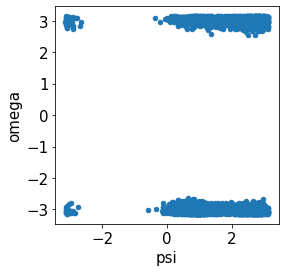

In [7]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
load_dataframe(folder+"COLVAR").plot.scatter(y="omega",x="psi",ax=ax)

In [8]:
#-- TRAINING PARAMETERS --#
train_parameters = {
              'descriptors': '^d[^a-z]',
              'lag_time':1,
              'standardize_outputs':True,
              'standardize_inputs': True,
              #if reweight the timescale
              "reweighting": False,
              "step": 1 #se prendo tutti i valori fallisce il cholesky decomposition.. issue con pytorch
              }
#--------------------------------------#

In [9]:
data = load_dataframe(folder+"COLVAR")
data = data[:]
X, names, t = data.filter(regex='^d[^a-z]').values, data.filter(regex='^d[^a-z]').columns.values, data['time'].values

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

lags = np.linspace(1,10,10)
timescale = np.empty(len(lags))

for i,lag in enumerate(lags):
    # TRAIN
    model.fit(X, t, lag=lag)
    #-- move the model back to cpu for convenience --# 
    timescale[i] = model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1]
model.to('cpu')

TICA_CV()

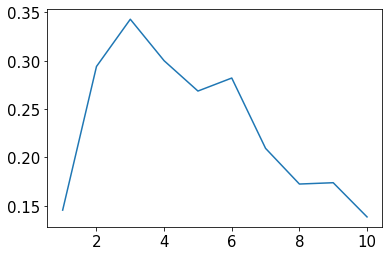

In [10]:
plt.plot(lags,timescale)
#print(timescale)
#print(lags)

## DeepTICA Analysis and Export

In [11]:
torch.manual_seed(21)
# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = TICA_CV(n_features=X.shape[1])
model.to(device)

# TRAIN
model.fit(X, t, lag=1)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
#print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())
#print("gap: ", model.tica.evals_.detach().cpu().numpy()[0]-model.tica.evals_.detach().cpu().numpy()[1])

model.set_params({"feature_names": names})
print( model.plumed_input().splitlines()[:2] )

eigenvalues:  [ 0.73498493  0.5894111   0.55418414  0.33261746  0.31178656  0.2760685
  0.24257882  0.22785994  0.2125074   0.19593303  0.1764373   0.16858639
  0.1575654   0.1451584   0.13297102  0.13000306  0.12078459  0.10992461
  0.09351391  0.08498456  0.07658392  0.06626666  0.05033999  0.04257125
  0.03745503  0.03210727  0.02552567  0.00616157 -0.00114919 -0.01566087
 -0.02297783 -0.04053722 -0.05044632 -0.06045849 -0.07555829 -0.10166968
 -0.14168516 -0.17400339 -0.19475912 -0.2209952  -0.24208015 -0.252212
 -0.28208867 -0.2991447  -0.44944993]
['tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.029637*(x0-0.151295)-0.030169*(x1-0.237500)-0.040216*(x2-0.242272

#### Adding to data the cvs values

In [12]:
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("../../angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [13]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data["cv3"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[2]
data["cv4"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[3]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]
data_complete["cv3"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[2]
data_complete["cv4"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[3]

<AxesSubplot:ylabel='Frequency'>

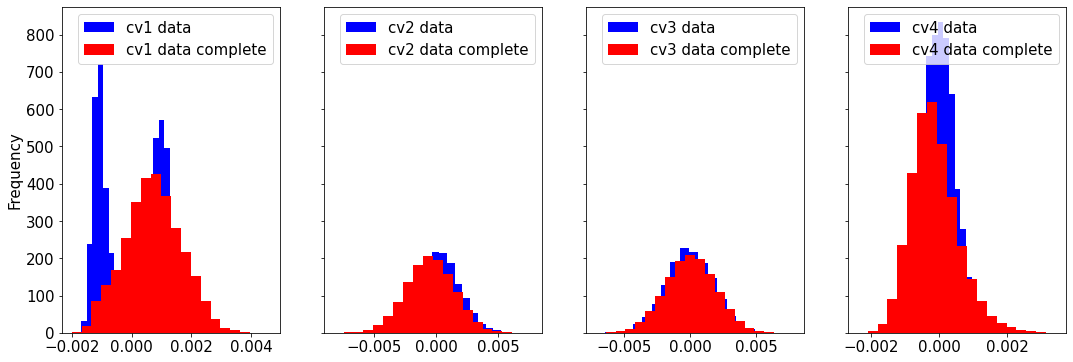

In [14]:
fig,axs = plt.subplots(1,4,figsize=(18,6),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b",label="cv1 data")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="b",label="cv2 data")
data.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="b",label="cv3 data")
data.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="b",label="cv4 data")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="r",label="cv1 data complete")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r",label="cv2 data complete")
data_complete.plot.hist(y="cv3",bins=20,ax=axs[2],density=True,color="r",label="cv3 data complete")
data_complete.plot.hist(y="cv4",bins=20,ax=axs[3],density=True,color="r",label="cv4 data complete")

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

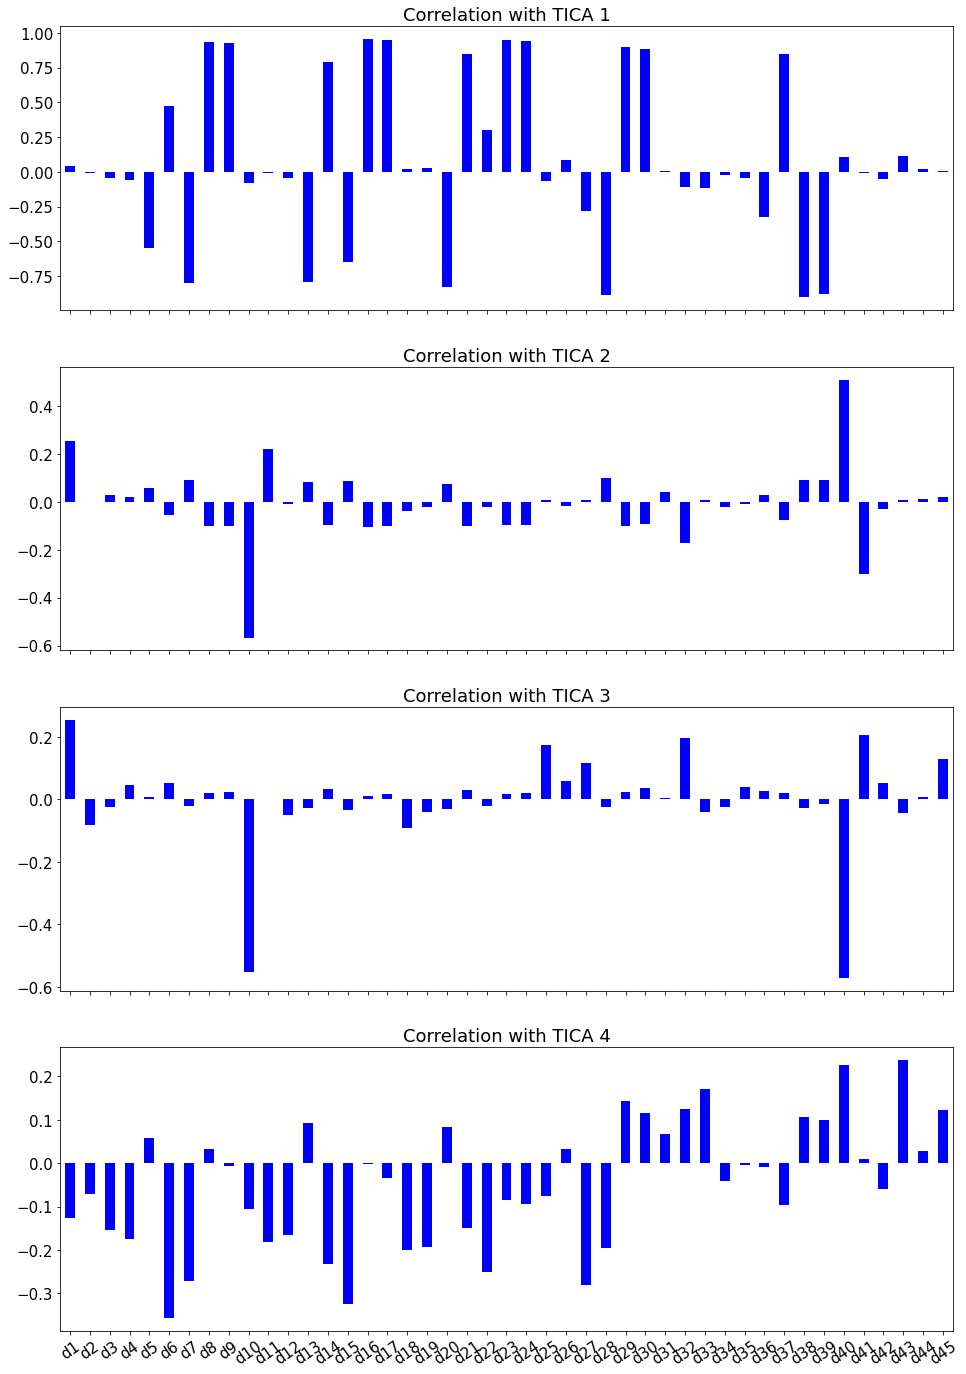

In [15]:
fig,axs = plt.subplots(4,1,figsize=(16,24),sharex=True)
for k,cv in enumerate(["cv1","cv2","cv3","cv4"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(tica|desc)$")
    axs[k].set_title('Correlation with TICA '+str(k+1))
plt.show()

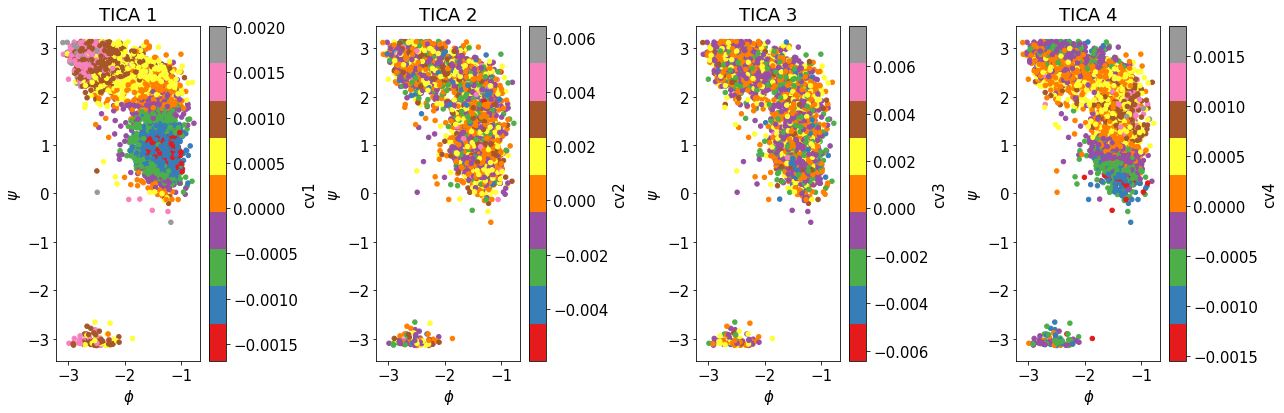

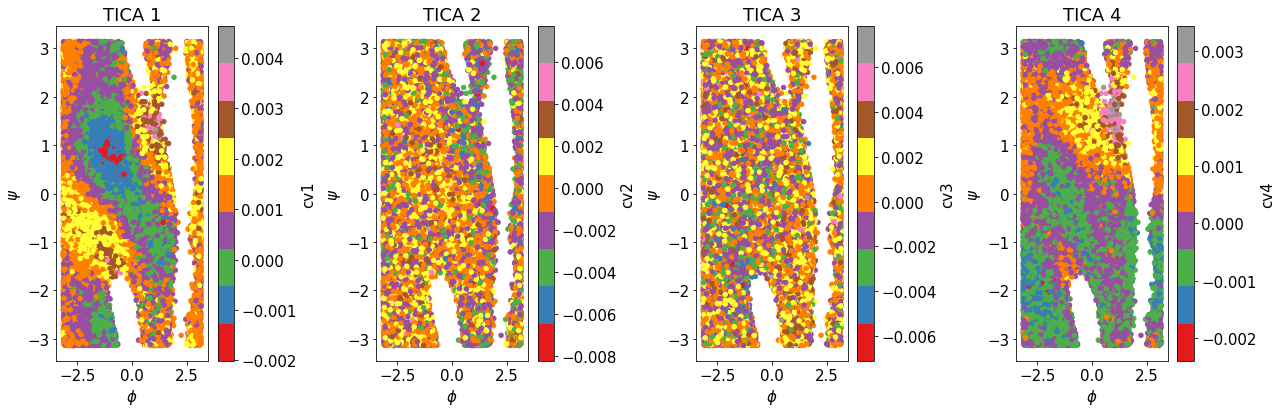

In [16]:
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(18,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('TICA '+str(k+1))
plt.tight_layout()

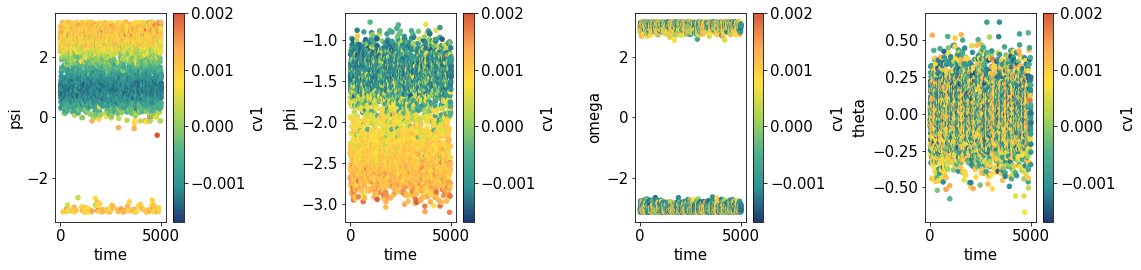

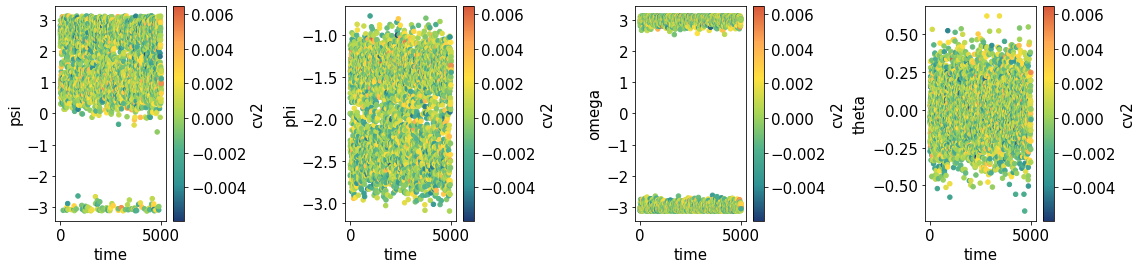

In [17]:
names = ["psi","phi","omega","theta"]
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv1",cmap="fessa",ax=ax)
plt.tight_layout()
fig,axs = plt.subplots(1,4,figsize=(16,4))
for i,ax in enumerate(axs):
    data.plot.scatter(y=names[i],x="time",c="cv2",cmap="fessa",ax=ax)
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [18]:
Boltzmann_product(model,model,X,j=0,k=1)

-1.5407678909346646e-09

# Prepare the next simulation input files
### Plumed

In [23]:
folder = "unbias_A/bias1/"
Path(folder).mkdir(parents=True, exist_ok=True)

with open(folder+"plumed.dat","w") as file:
    print("""
# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
"""+
model.plumed_input().splitlines()[0]+"""\n"""+model.plumed_input().splitlines()[1]
+"""
# bias 
opes: OPES_METAD ARG=tica_cv1,tica_cv2 TEMP=300 PACE=500 FILE=KERNELS BARRIER=40 STATE_WFILE=RestartKernels STATE_WSTRIDE=500*10
 
PRINT FMT=%g STRIDE=500 FILE=COLVAR ARG=*

ENDPLUMED
""",file=file)

#-- run gromacs --#
execute("cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh "+folder,folder=".")

Completed: cp script/input.* script/plumed_descriptors.data script/run_gromacs.sh unbias_A/bias1/


In [24]:
!cat unbias_A/bias1/plumed.dat


# vim:ft=plumed

MOLINFO STRUCTURE=input.ala2.pdb
phi: TORSION ATOMS=@phi-2 
psi: TORSION ATOMS=@psi-2
omega: TORSION ATOMS=5,6,7,9
theta: TORSION ATOMS=9,15,17,18

#energy
ene: ENERGY

# include descriptors
INCLUDE FILE=plumed_descriptors.data
# define cv
tica_cv1: CUSTOM ARG=d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45 VAR=x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44 FUNC=0.029637*(x0-0.151295)-0.030169*(x1-0.237500)-0.040216*(x2-0.242272)-0.039141*(x3-0.381717)+0.002893*(x4-0.469097)+0.225153*(x5-0.466701)-0.117858*(x6-0.518403)-0.004963*(x7-0.519856)-0.040199*(x8-0.634493)+0.051730*(x9-0.122465)+0.078022*(x10-0.133311)+0.146658*(x11-0.247859)-0.011478*(x12-0.352353)-0.716243*(x13-0.342903)+0.393391*(x14-0.415064)+0.111528*(x15-0.39313

### Gromacs

In [25]:
# da corregere questo sed.. mi modifica anche quello che c'è dentro l'if, ${cpi_state}
#execute("sed -i 's/cpi_state.*/cpi_state=true/g' run_gromacs.sh",folder=folder, print_result=False)
execute("sed -i 's/cpi_state.*/cpi_state=true/' run_gromacs.sh",folder=folder, print_result=False)

execute("cp ../alanine.* .",folder=folder, print_result=False)

In [22]:
!cat unbias_A/bias1/run_gromacs.sh

#!/bin/bash

date

### compulsory ###
ncore=1
tprfile=input.sA.tpr
gmx=`which gmx_mpi`
script=/home/npedrani@iit.local/Desktop/Phd_main_Projects/Hyper-TICA/Alanine/script/bck.meup.sh
pin_offset=0
cpi_state=true

### optional ###
nsteps=$[500*1000*5] #last is ns
ntomp=2
#maxh=1:00 #h:min
filename=alanine
plumedfile=plumed.dat
extra_cmd=""

echo gromacs for $nsteps steps

### setup ###
[ -z "$filename" ]  && filename=simulation
outfile=${filename}.out
[ -z "$plumedfile" ] || plumedfile="-plumed $plumedfile"
[ -z "$ntomp" ] || ntomp="-ntomp $ntomp"
[ -z "$nsteps" ] || nsteps="-nsteps $nsteps"
if [ ! -z "$maxh" ]
then
  maxh=`python <<< "print('%g'%(${maxh%:*}+${maxh#*:}/60))"`
  maxh="-maxh $maxh"
fi

### commands ###
#mpi_cmd="$gmx mdrun -s $tprfile -deffnm $filename $plumedfile $ntomp $nsteps $maxh"

if [${cpi_state=true
then
  mpi_cmd="$gmx mdrun -s $tprfile -deffnm $filename $plumedfile $ntomp $nsteps -cpi $filename"
else
  mpi_cmd="$gmx mdrun -s $tprfile -deffnm $filename $plumedfile